# Problem type
**Multi-class classification**	Target can be one of more than two options	Decide whether a photo of is of food, a person or a dog.

**Multi-label classification**	Target can be assigned more than one option	Predict what categories should be assigned to a Wikipedia article (e.g. mathematics, science & philosohpy).

# Architecture of a classification neural network
| Hyperparameter                  | Binary Classification                                                                                                                                  | Multiclass Classification                                               |
|---------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------|
| Input layer shape (in_features) | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction)                                             | Same as binary classification                                           |
| Hidden layer(s)                 | Problem specific, minimum = 1, maximum = unlimited                                                                                                     | Same as binary classification                                           |
| Neurons per hidden layer        | Problem specific, generally 10 to 512                                                                                                                   | Same as binary classification                                           |
| Output layer shape (out_features) | 1 (one class or the other)                                                                                                                            | 1 per class (e.g. 3 for food, person or dog photo)                      |
| Hidden layer activation         | Usually ReLU (rectified linear unit) but can be many others                                                                                            | Same as binary classification                                           |
| Output activation               | Sigmoid (torch.sigmoid in PyTorch)                                                                                                                      | Softmax (torch.softmax in PyTorch)                                      |
| Loss function                   | Binary crossentropy (torch.nn.BCELoss in PyTorch)                                                                                                       | Cross entropy (torch.nn.CrossEntropyLoss in PyTorch)                    |
| Optimizer                       | SGD (stochastic gradient descent), Adam (see torch.optim for more options)                                                                              | Same as binary classification                                           |


# 1. Make classification data

In [1]:
import sklearn
from sklearn.datasets import make_circles


# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


## Pandas

In [2]:
# Make DataFrame of circle data
# Create a dictionary with the data
# Create the DataFrame "data", pass the dictionary to it "df = pd.DataFrame(data)"
# Display the DataFrame "print(df)"
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y
                        })
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [3]:
# Check different labels
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

## Visualize

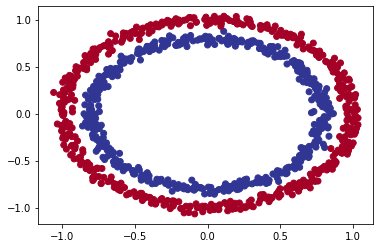

In [4]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);#semicolon

#plt.scatter is a function in Matplotlib used to create a scatter plot, which is a type of plot that displays points based on their coordinates.

#c=y: The c parameter sets the color of the points. Here, y is used to determine the color of each point.
#Typically, y represents the target variable or class labels, so each point is colored based on its corresponding value in y.

#The cmap parameter specifies the colormap to use for coloring the points. 
#plt.cm.RdYlBu is a specific colormap in Matplotlib that ranges from red to yellow to blue.
#This creates a gradient of colors representing different values of y.

#The semicolon at the end of the line suppresses the output of the plot command in some interactive environments like Jupyter Notebooks, 
#so that only the plot is displayed and not additional text output.

* Toy problem -> a problem that's used to try and test things out on in machine learning.

## 1.1 Input and output shapes

In [5]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


## 1.2 Turn data into tensors and create train and test splits

In [7]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)#will give float32
y = torch.from_numpy(y).type(torch.float)
#numpy is float64, tensors are floate32 by default
# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [8]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

# setting torch.manual_seed(42) will only affect pytorch code and not scikit-learn code 
#so we have to mention random_state

(800, 200, 800, 200)

# 2. Building a model

In [9]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Let's create a model class that:

1. Subclasses `nn.Module` (almost all PyTorch models are subclasses of `nn.Module`).
2. Creates 2 `nn.Linear` layers in the constructor capable of handling the input and output shapes of `X` and `y`.
3. Defines a `forward()` method containing the forward pass computation of the model.
4. Instantiates the model class and sends it to the target device.


In [10]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1=nn.Linear(in_features=2 , out_features=5)# takes in 2 features (X), produces 5 features
        self.layer_2=nn.Linear(in_features=5 , out_features=1)# takes in 5 features, produces 1 feature (y)

    # 3. Define a forward method containing the forward pass computation
    def forward(self , x):
        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_2(self.layer_1(x))# computation goes through layer_1 first then the output of layer_1 goes through layer_2

# 4. Create an instance of the model and send it to target device
model_0=CircleModelV0().to(device)
model_0


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

self.layer_1 takes 2 input features in_features=2 and produces 5 output features out_features=5.

This is known as having 5 hidden units or neurons.

This allows the model to learn patterns from 5 numbers rather than just 2 numbers, potentially leading to better outputs.

## playground.tensor
......helps visualize NNs
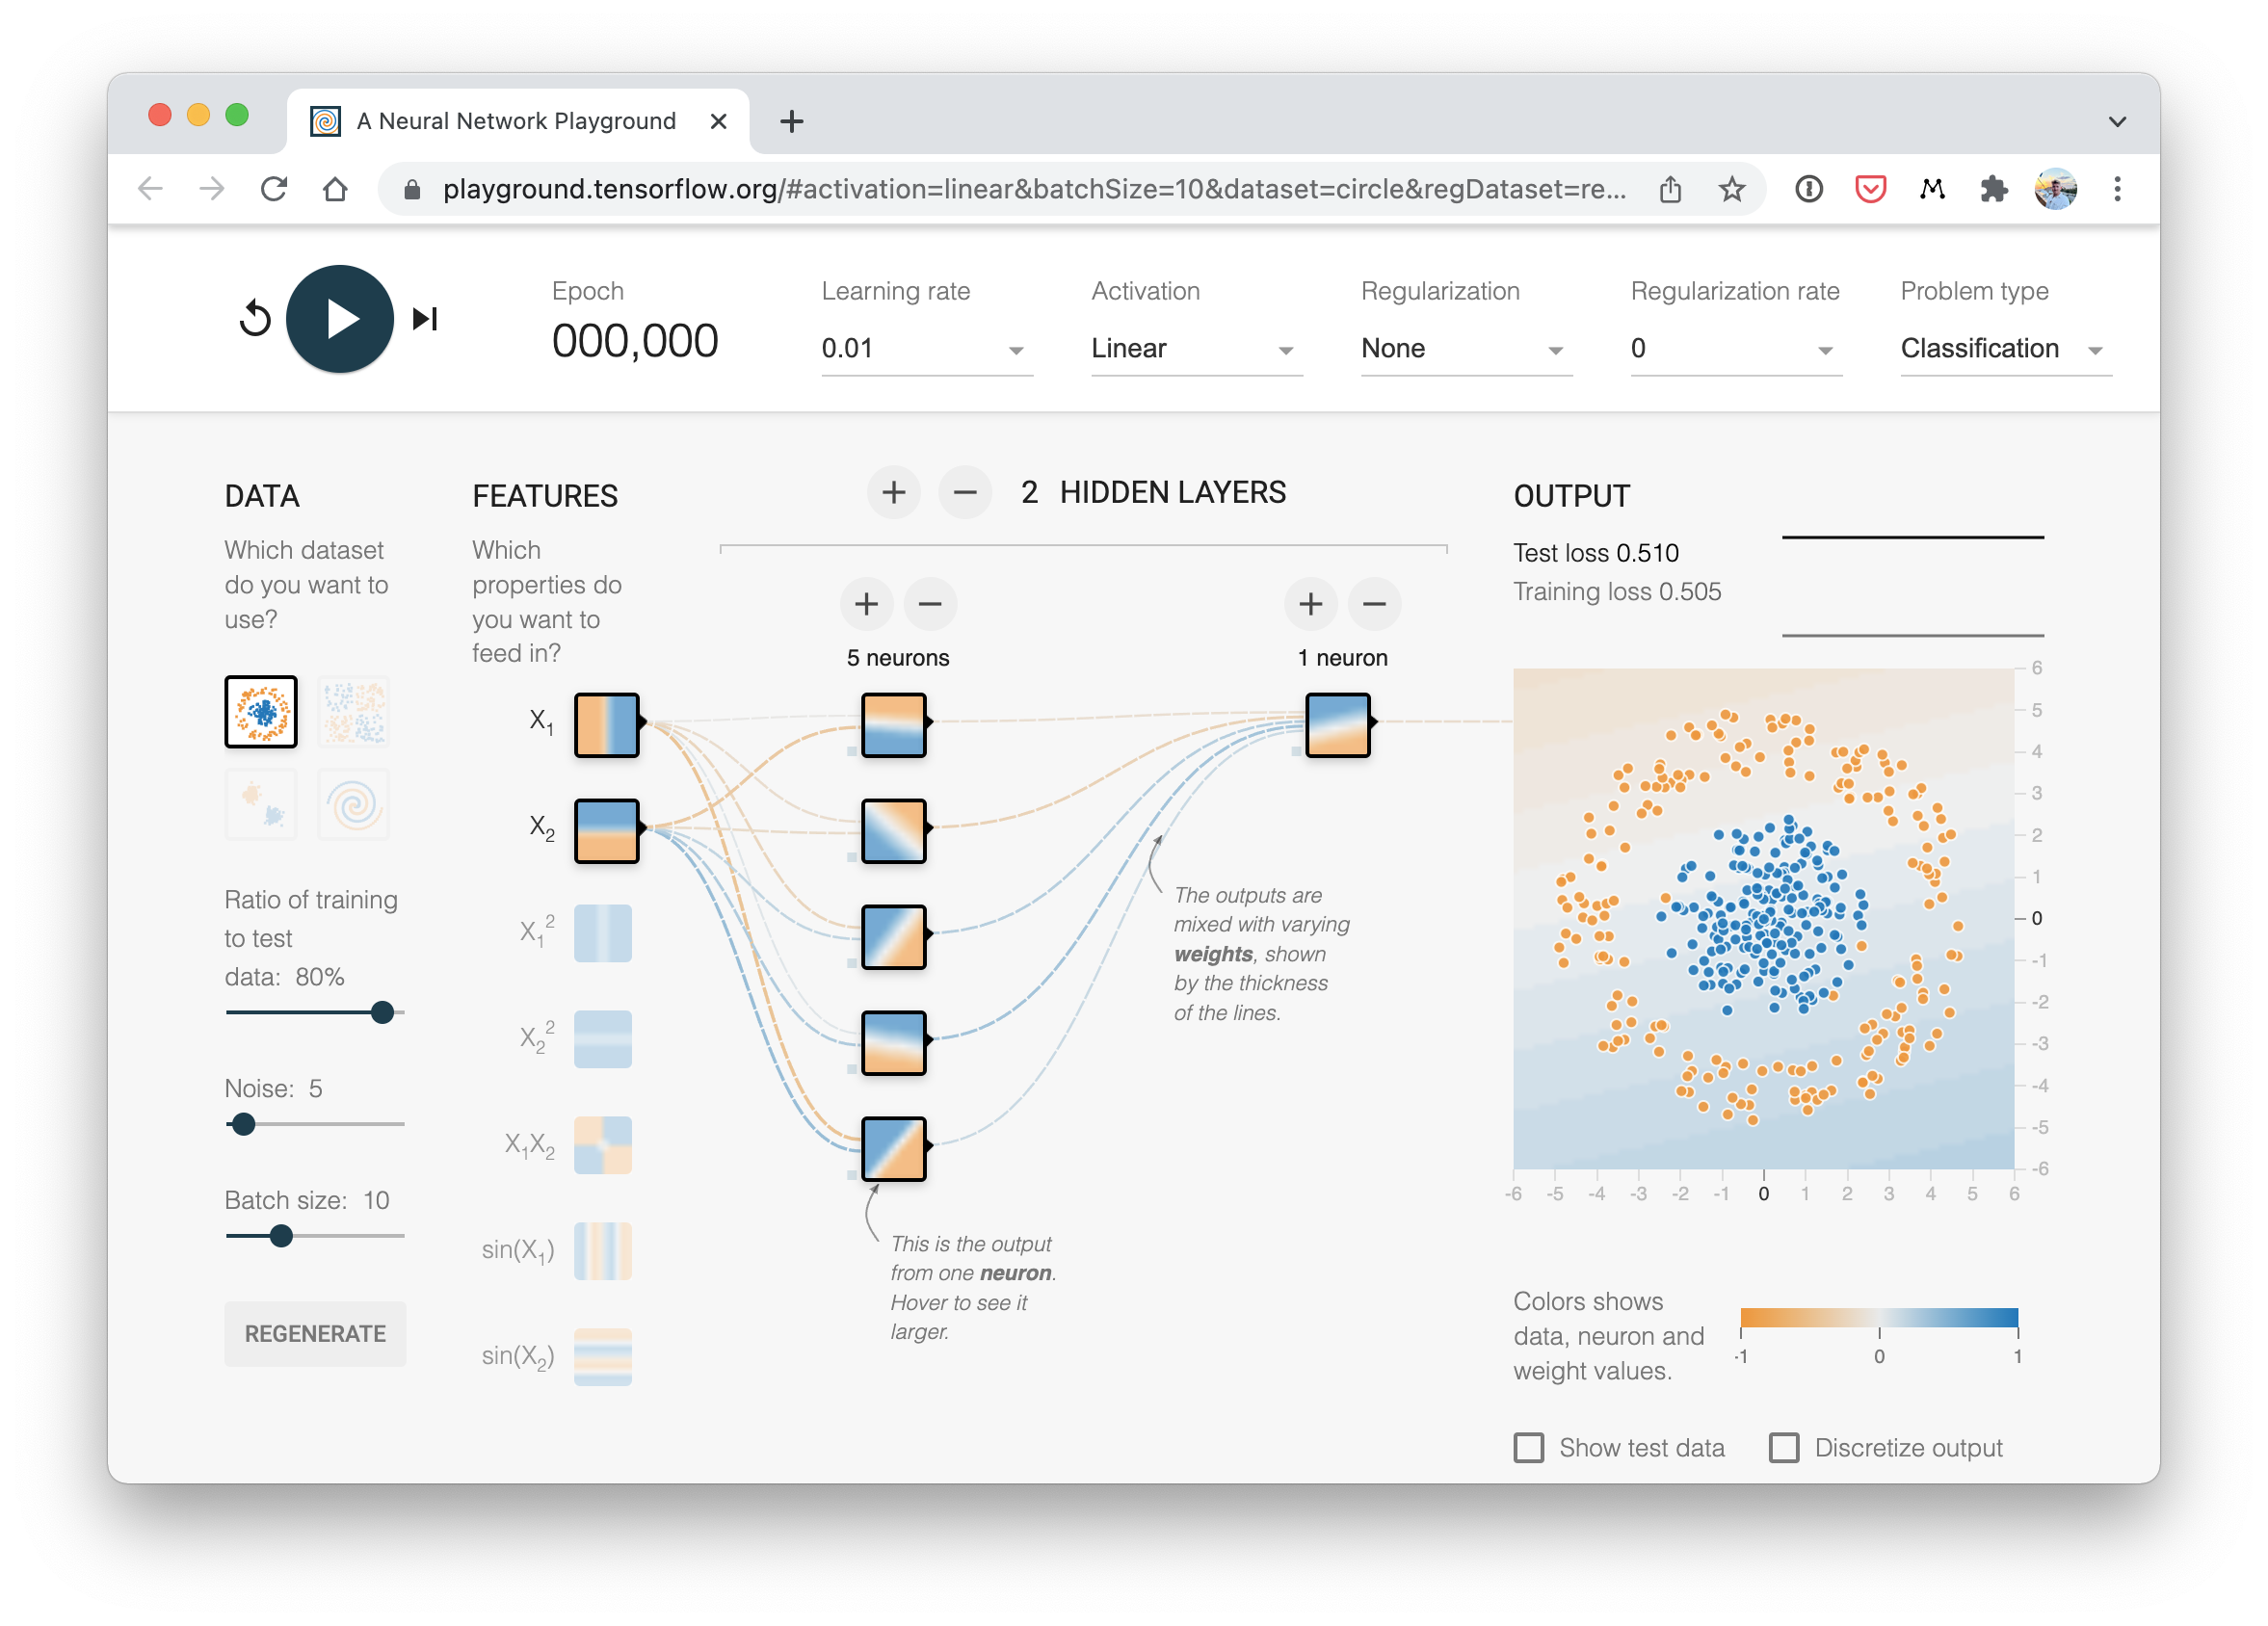

##  nn.Sequential

nn.Sequential is fantastic for straight-forward computations, however, as the namespace says, it always runs in sequential order.

So if you'd something else to happen (rather than just straight-forward sequential computation) you'll want to define your own custom nn.Module subclass.

In [ ]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict()
#look at the shapes of weights and biases for each layer 0,1

OrderedDict([('0.weight',
              tensor([[-0.4869,  0.6106],
                      [-0.6742, -0.2598],
                      [ 0.0987,  0.6027],
                      [ 0.3833, -0.6400],
                      [ 0.6172,  0.6535]], device='cuda:0')),
             ('0.bias',
              tensor([-0.2396,  0.5948,  0.1373, -0.0660, -0.6717], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.2347, -0.2286, -0.1634,  0.1176,  0.0472]], device='cuda:0')),
             ('1.bias', tensor([-0.1897], device='cuda:0'))])

In [ ]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

model_0.eval()
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")


Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.4398],
        [-0.3850],
        [-0.5315],
        [-0.4140],
        [-0.4488],
        [-0.4160],
        [-0.3272],
        [-0.3343],
        [-0.5349],
        [-0.3803]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])
Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.4398],
        [-0.3850],
        [-0.5315],
        [-0.4140],
        [-0.4488],
        [-0.4160],
        [-0.3272],
        [-0.3343],
        [-0.5349],
        [-0.3803]], device='cuda:0')

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


## 2.1 Setup loss function and optimizer

| Loss function/Optimizer            | Problem type                          | PyTorch Code                        |
|------------------------------------|---------------------------------------|-------------------------------------|
| Stochastic Gradient Descent (SGD) optimizer | Classification, regression, many others. | `torch.optim.SGD()`                 |
| Adam Optimizer                     | Classification, regression, many others. | `torch.optim.Adam()`                |
| Binary cross entropy loss          | Binary classification                 | `torch.nn.BCELossWithLogits` or `torch.nn.BCELoss` |
| Cross entropy loss                 | Multi-class classification            | `torch.nn.CrossEntropyLoss`         |
| Mean absolute error (MAE) or L1 Loss | Regression                           | `torch.nn.L1Loss`                   |
| Mean squared error (MSE) or L2 Loss | Regression                           | `torch.nn.MSELoss`                  |


The documentation for torch.nn.BCEWithLogitsLoss() states that it's more numerically stable than using torch.nn.BCELoss() after a nn.Sigmoid layer.

In [ ]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.1)

## 2.2 Evaluation metric

sklearn.metrics

In [ ]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

# 3. Train model

**Zero gradients** - The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step (optimizer.zero_grad()).

**Perform backpropagation on the loss** - Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with requires_grad=True). This is known as backpropagation, hence "backwards" (loss.backward()).

**Step the optimizer (gradient descent)** - Update the parameters with requires_grad=True with respect to the loss gradients in order to improve them (optimizer.step()).


* 3.1 Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)

In [ ]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.4398],
        [-0.3850],
        [-0.5315],
        [-0.4140],
        [-0.4488]], device='cuda:0', grad_fn=<SliceBackward0>)

The raw outputs of our model are often referred to as logits.However, these numbers are hard to interpret.

We'd like some numbers that are comparable to our truth labels.

To get our model's raw outputs (logits) into such a form, we can use the sigmoid activation function.

In [ ]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs #They're now in the form of prediction probabilities 

tensor([[0.3918],
        [0.4049],
        [0.3702],
        [0.3979],
        [0.3896]], device='cuda:0', grad_fn=<SigmoidBackward0>)

To turn our prediction probabilities in prediction labels, we can round the outputs of the sigmoid activation function.

In [ ]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

## 3.2 Building a training and testing loop

In [ ]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
  
    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71779, Accuracy: 50.00% | Test loss: 0.71733, Test acc: 50.00%
Epoch: 10 | Loss: 0.70190, Accuracy: 50.00% | Test loss: 0.70147, Test acc: 50.00%
Epoch: 20 | Loss: 0.69665, Accuracy: 50.00% | Test loss: 0.69584, Test acc: 50.00%
Epoch: 30 | Loss: 0.69481, Accuracy: 50.00% | Test loss: 0.69376, Test acc: 50.00%
Epoch: 40 | Loss: 0.69409, Accuracy: 50.00% | Test loss: 0.69300, Test acc: 50.00%
Epoch: 50 | Loss: 0.69376, Accuracy: 50.00% | Test loss: 0.69275, Test acc: 50.00%
Epoch: 60 | Loss: 0.69357, Accuracy: 49.38% | Test loss: 0.69273, Test acc: 48.50%
Epoch: 70 | Loss: 0.69345, Accuracy: 42.62% | Test loss: 0.69280, Test acc: 44.00%
Epoch: 80 | Loss: 0.69336, Accuracy: 40.50% | Test loss: 0.69290, Test acc: 43.00%
Epoch: 90 | Loss: 0.69329, Accuracy: 42.12% | Test loss: 0.69302, Test acc: 45.50%


# 4. Make predictions and evaluate the model

To do so, we'll write some code to download and import the ***helper_functions.py*** script from the Learn PyTorch for Deep Learning repo.

It contains a helpful function called ***plot_decision_boundary()*** which creates a NumPy meshgrid to visually plot the different points where our model is predicting certain classes.

In [ ]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f: #wb gives write permission to file f
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

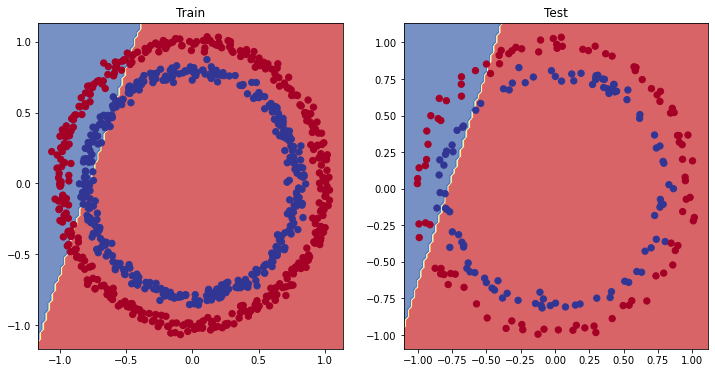

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# 5. Improving a model (from a model perspective)

| Model improvement technique      | What does it do?                                                                                                                  |
|----------------------------------|-----------------------------------------------------------------------------------------------------------------------------------|
| Add more layers                  | Each layer potentially increases the learning capabilities of the model with each layer being able to learn some kind of new pattern in the data, more layers is often referred to as making your neural network deeper. |
| Add more hidden units            | Similar to the above, more hidden units per layer means a potential increase in learning capabilities of the model, more hidden units is often referred to as making your neural network wider.                        |
| Fitting for longer (more epochs) | Your model might learn more if it had more opportunities to look at the data.                                                     |
| Changing the activation functions| Some data just can't be fit with only straight lines (like what we've seen), using non-linear activation functions can help with this (hint, hint).                                 |
| Change the learning rate         | Less model specific, but still related, the learning rate of the optimizer decides how much a model should change its parameters each step, too much and the model overcorrects, too little and it doesn't learn enough.|
| Change the loss function         | Again, less model specific but still important, different problems require different loss functions. For example, a binary cross entropy loss function won't work with a multi-class classification problem.           |
| Use transfer learning            | Take a pretrained model from a problem domain similar to yours and adjust it to your own problem. We cover transfer learning in notebook 06.                                   |



* because you can adjust all of these by hand, they're referred to as hyperparameters.

In [ ]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x): # note: always make sure forward is spelt correctly!
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [ ]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> predicition probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.50% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.50% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 45.50%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


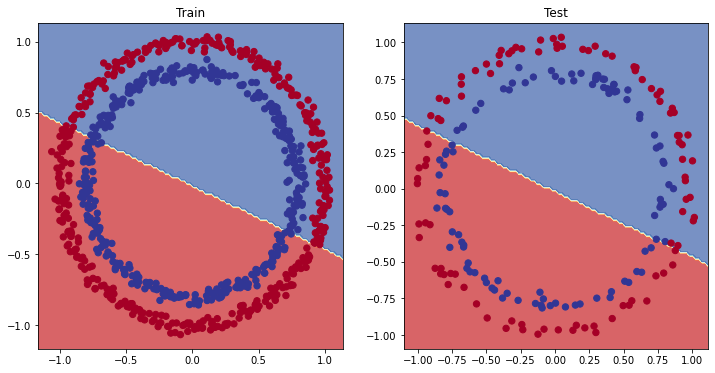

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## 5.1 Preparing data to see if our model can model a straight line

In [ ]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [ ]:
# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression), 
    len(y_train_regression), 
    len(X_test_regression), 
    len(y_test_regression))

80 80 20 20


let's see how the data looks.

To do so, we'll use the plot_predictions() function we created in notebook 01.

It's contained within the helper_functions.py script on the Learn PyTorch for Deep Learning repo which we downloaded above.

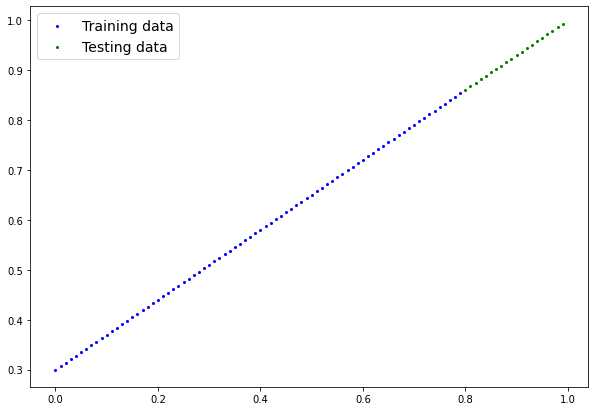

In [ ]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

## 5.2 Adjusting model_1 to fit a straight line

In [ ]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.01)
# we changed the lr from 0.1 yo 0.01 and sa the loss going down.

In [ ]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training 
    # 1. Forward pass
    y_pred = model_2(X_train_regression)
    
    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_pred = model_2(X_test_regression)
      # 2. Calculate the loss 
      test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0: 
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.05502, Test loss: 0.11336
Epoch: 100 | Train loss: 0.00543, Test loss: 0.01380
Epoch: 200 | Train loss: 0.00598, Test loss: 0.01374
Epoch: 300 | Train loss: 0.00603, Test loss: 0.01360
Epoch: 400 | Train loss: 0.00567, Test loss: 0.01420
Epoch: 500 | Train loss: 0.00571, Test loss: 0.01433
Epoch: 600 | Train loss: 0.00566, Test loss: 0.01415
Epoch: 700 | Train loss: 0.00593, Test loss: 0.01404
Epoch: 800 | Train loss: 0.00596, Test loss: 0.01399
Epoch: 900 | Train loss: 0.00593, Test loss: 0.01374


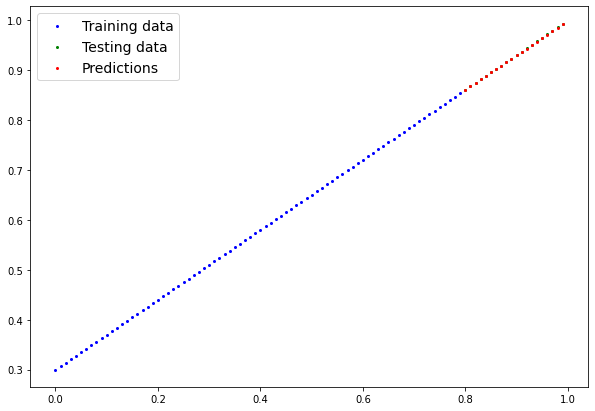

In [ ]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

# 6. The missing piece: non-linearity

## 6.1 Recreating non-linear data (red and blue circles)

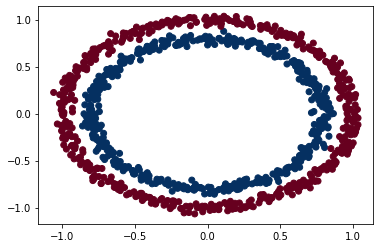

In [11]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [12]:
import torch
from sklearn.model_selection import train_test_split

X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

## 6.2 Building a model with non-linearity

PyTorch has a bunch of ready-made non-linear activation functions that do similiar but different things.
https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

* nn.Softmax ->Applies the Softmax function to an n-dimensional input Tensor.
nn.

* Tanh ->Applies the Hyperbolic Tangent (Tanh) function element-wise.

* nn.ReLU ->Applies the rectified linear unit function element-wise.

In [15]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1=nn.Linear(in_features=2, out_features=10)
        self.layer_2=nn.Linear(in_features=10, out_features=10)
        self.layer_3=nn.Linear(in_features=10, out_features=10)
        self.relu=nn.ReLU()# <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3=CircleModelV2()
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=10, bias=True)
  (relu): ReLU()
)

In [27]:
device
model_3.to(device)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [20]:
# Check if CUDA is available
print("CUDA available:", torch.cuda.is_available())
# Check the number of available GPUs
print("Number of GPUs:", torch.cuda.device_count())
# Check the name of the GPU
print("GPU Name:", torch.cuda.get_device_name(0))

CUDA available: True
Number of GPUs: 3
GPU Name: NVIDIA GeForce RTX 3090


In [25]:
# Clear cache and collect garbage
import gc
gc.collect()
torch.cuda.empty_cache()

In [26]:

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')